# Initialize the workspace

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import os

datasets_dir= "../DataSet"

def save_dataset(df,dataset_Path):
    if(os.path.isfile(dataset_Path)):
        print("Updating dataset ",dataset_Path,df.shape)
        df.to_csv(dataset_Path, mode='a', index= False,header=False)
    else:
        print("Creating dataset",dataset_Path,df.shape)
        df.to_csv(dataset_Path, index= False)
        
def visualize_unique_values(df,savefile):
    #check unique value for each column attacks,event
    print('_________ Type attacks _________$')
    print(pd.DataFrame([df['Label'].unique(),
        [df[df['Label']==value]['Label'].value_counts()[0] for value in df['Label'].unique()]]))
    print('_________              _________$')        
    sns.set(rc={'figure.figsize':(15.7,8.27)})
    #Plot Bar chart to understand event total of device
    p=sns.countplot(x='Label', data=df)
    plt.show()
    plt.clf()
    plt.savefig(savefile)
    
def visualize_correlation(df,savefile):
    
    # To find the correlation among 
    # the columns using pearson method 
    matrix_corr_pearson=df.corr(method ='pearson',numeric_only=True)
    matrix_corr_pearson.to_csv( savefile+".csv")
    sns.set(rc={'figure.figsize':(80,80)})
    sns.heatmap(matrix_corr_pearson, 
                xticklabels=matrix_corr_pearson.columns,
                yticklabels=matrix_corr_pearson.columns,
                cmap='RdBu_r',
                annot=True,
                linewidth=0.5)
    plt.show()
    plt.clf()    
    plt.savefig(savefile+".png")

# Feature engineering

## ridgecv features selection

Best alpha using built-in RidgeCV:  1.0
Best score using built-in RidgeCV:  0.7809832592316046
Ridge picked  66  variables and eliminated the other  12  variables


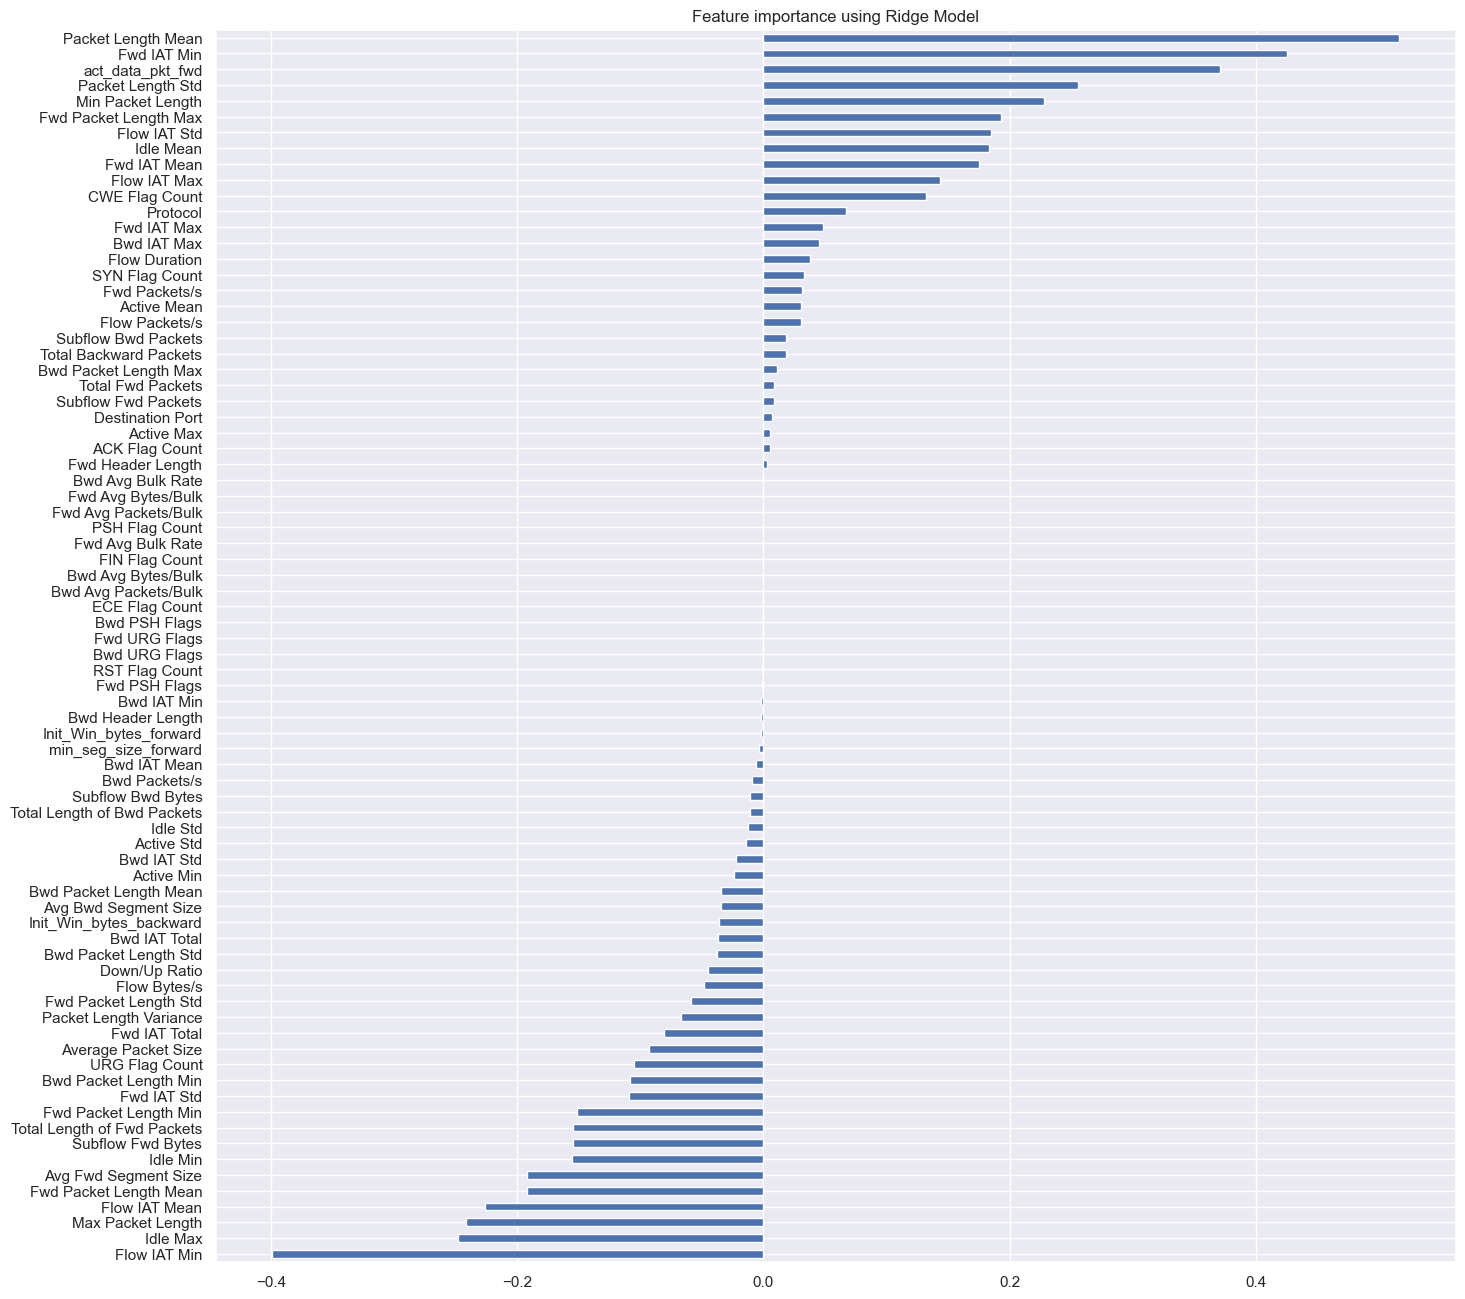

Elementated features are :
Index(['Bwd URG Flags', 'Fwd URG Flags', 'Bwd PSH Flags', 'ECE Flag Count',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bytes/Bulk', 'FIN Flag Count',
       'Fwd Avg Bulk Rate', 'PSH Flag Count', 'Fwd Avg Packets/Bulk',
       'Fwd Avg Bytes/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

<Figure size 1600x1600 with 0 Axes>

In [7]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Load Data
df=pd.read_csv(os.path.join(datasets_dir,"Dataset_Cleaned.csv"),low_memory=False)

#setting up the Tools
le = LabelEncoder()
scaler = StandardScaler(with_mean=True, with_std=True)
reg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5)

#droping timestamp
df.drop(columns='Timestamp',inplace=True)

# Replace infinite updated data with nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
df.dropna(inplace=True)

#encoding Labels
labels=df["Label"]
label = le.fit_transform(labels)
df.drop('Label', axis=1,inplace=True)
df['Label'] = label

#spliting targete
X=df.drop('Label', axis=1)
y=df['Label']
col=X.columns

# Standardize the data 
X=scaler.fit_transform(X)

#fitting the estimator
reg.fit(df, y)

#calculating the scors
score=reg.score(df,y)
enumerate
# print results
print("Best alpha using built-in RidgeCV: ", reg.alpha_)
print("Best score using built-in RidgeCV: ", score)
print("Ridge picked ", np.sum(reg.coef_  != 0), 
      " variables and eliminated the other ", 
      np.sum(reg.coef_  == 0), " variables")

# plot feature importance
coef = pd.Series(reg.coef_ , index=df.col)
imp_coef = coef.sort_values()
sns.set(rc={'figure.figsize':(16,16)})
imp_coef.plot(kind = "barh") 
plt.title("Feature importance using Ridge Model")
plt.show()
plt.savefig("Feature_Importance.png")
        
print("Elementated features are :")
print(imp_coef[coef==0].index)


df.drop(columns=imp_coef[coef==0].index, inplace=True)
save_dataset(df,os.path.join(datasets_dir,"dataset_after_full_ridge.csv"))

In [5]:
labels.head()

0    DrDoS_DNS
1    DrDoS_DNS
2    DrDoS_DNS
3    DrDoS_DNS
4    DrDoS_DNS
Name: Label, dtype: object

## correlation feature elimination

In [ ]:
visualize_correlation(df,"dataset_correltaion_after_ridge")

In [ ]:
correlated_columns=['Flow Duration','Flow IAT Mean','Flow IAT Std','Fwd IAT Total','Fwd IAT Mean','Fwd IAT Std',
'Fwd IAT Max','Idle Mean','Idle Max','Fwd Packet Length Max','Fwd Packet Length Min',
'Fwd Packet Length Mean','Max Packet Length','Average Packet Size','Avg Fwd Segment Size',
'Bwd Packet Length Max','Bwd Packet Length Mean','Packet Length Std','Avg Bwd Segment Size',
'Total Backward Packets','Subflow Bwd Packets','Subflow Bwd Bytes','Active Max','Active Min',
'Bwd IAT Total','Bwd IAT Std','Subflow Fwd Packets','Subflow Fwd Bytes','Fwd Packets/s','Fwd IAT Min']
df.drop(columns=correlated_columns.index, inplace=True)

In [ ]:
visualize_correlation(df,"dataset_correltaion_after_correlation_elimination")

# Data enginnering

In [ ]:
#  SMOTE oversampling and random undersampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over),('under', under)]
pipeline = Pipeline(steps=steps)
X,y=pipeline.fit_resample(df.drop(columns="Label"),df["Label"])

dataset_resampled=pd.concat([pd.DataFrame(X), pd.DataFrame({'Label': y})], axis=1)
save_dataset(dataset_resampled,os.path.join(datasets_dir,"dataset_resampled_39F.csv"))

In [ ]:
# evaluate pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_before = cross_val_score(model, df.drop(columns="Label"),df["Label"], scoring='roc_auc', cv=cv, n_jobs=-1)
print('Before balencing Mean ROC AUC: %.3f' % np.mean(scores_before))
scores_after = cross_val_score(model, X,y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('After balancing Mean ROC AUC: %.3f' % np.mean(scores_after))

In [16]:
import pandas as pd
import os
dir={"Dataset_2017" : '../DataSet/2017/TrafficLabelling',
        "Dataset_2018" : '../DataSet/2018',
        "Dataset_2019" : '../DataSet/2019'}
normal_count= {"Dataset_2017" : 0,
        "Dataset_2018" : 0,
        "Dataset_2019" : 0}
attacks_count={"Dataset_2017" : 0,
        "Dataset_2018" : 0,
        "Dataset_2019" : 0}
count={"Dataset_2017" : 0,
        "Dataset_2018" : 0,
        "Dataset_2019" : 0}
for key,value in dir.items():
    for dataset in os.listdir(value):
        if dataset.endswith(".csv") :
            df_reader=pd.read_csv(os.path.join(value,dataset),chunksize=6000000,low_memory=False, encoding='latin1')
            print(dataset)
            for df in df_reader :  
                for i in df.columns:
                    df=df.rename(columns={i:i.strip()})
                if key!="Dataset_2018":
                    attacks_count[key] += df[df['Label']!="BENIGN"].shape[0]
                    normal_count[key] += df[df['Label']=="BENIGN"].shape[0]
                else:
                    attacks_count[key] += df[df['Label']!="Benign"].shape[0]
                    normal_count[key] += df[df['Label']=="Benign"].shape[0]
                count[key] += df.shape[0]
            print(key,count[key],"normal",normal_count[key],"attacks",attacks_count[key])


Friday-Afternoon-DDos.csv
Dataset_2017 225745 normal 97718 attacks 128027
Friday-Afternoon-PortScan.csv
Dataset_2017 512212 normal 225255 attacks 286957
Friday-Morning.csv
Dataset_2017 703245 normal 414322 attacks 288923
Monday.csv
Dataset_2017 1233163 normal 944240 attacks 288923
Thursday-Afternoon-Infilteration.csv
Dataset_2017 1521765 normal 1232806 attacks 288959
Thursday-Morning-WebAttacks.csv
Dataset_2017 1980733 normal 1400992 attacks 579741
Tuesday.csv
Dataset_2017 2426642 normal 1833066 attacks 593576
Wednesday.csv
Dataset_2017 3119345 normal 2273097 attacks 846248
02-14-2018.csv
Dataset_2018 1048575 normal 667626 attacks 380949
02-15-2018.csv
Dataset_2018 2097150 normal 1663703 attacks 433447
02-16-2018.csv
Dataset_2018 3145725 normal 2110475 attacks 1035250
02-20-2018.csv
Dataset_2018 11094473 normal 9483032 attacks 1611441
02-21-2018.csv
Dataset_2018 12143048 normal 9843865 attacks 2299183
02-22-2018.csv
Dataset_2018 13191623 normal 10892078 attacks 2299545
02-23-2018.csv
D

MemoryError: Unable to allocate 45.8 MiB for an array with shape (6000000,) and data type int64

In [18]:

for dataset in os.listdir(value):
    if dataset in ["TFTP.csv","UDP.csv","UDPLag.csv","UDPLag_01-12.csv"] :
        df_reader=pd.read_csv(os.path.join(value,dataset),chunksize=4000000,low_memory=False, encoding='latin1')
        print(dataset)
        for df in df_reader :
            attacks_count[key] += df[df[' Label']!="BENIGN"].shape[0]
            normal_count[key] += df[df[' Label']=="BENIGN"].shape[0]
            count[key] += df.shape[0]
        print(key,count[key],"normal",normal_count[key],"attacks",attacks_count[key])

TFTP.csv
Dataset_2019 71662392 normal 218214 attacks 71444178
UDP.csv
Dataset_2019 75444598 normal 221348 attacks 75223250
UDPLag.csv
Dataset_2019 76169763 normal 225416 attacks 75944347
UDPLag_01-12.csv
Dataset_2019 76540368 normal 229121 attacks 76311247


In [19]:
for key in dir.keys():
    print(key,count[key],"normal",normal_count[key],"attacks",attacks_count[key])

Dataset_2017 3119345 normal 2273097 attacks 846248
Dataset_2018 16233002 normal 13484708 attacks 2748294
Dataset_2019 76540368 normal 229121 attacks 76311247


In [20]:
datasets=['attacks_2017.csv',"attacks_2018.csv","attacks_2019_300_clean.csv"]
for dataset in datasets:
    df= pd.read_csv(dataset)
    print(dataset,df.shape)

attacks_2017.csv (379736, 79)
attacks_2018.csv (995964, 79)
attacks_2019_300_clean.csv (4191525, 79)


In [21]:
datasets=['attacks_augmented.csv',"../DataSet/normal_dataset.csv"]
for dataset in datasets:
    df= pd.read_csv(dataset)
    print(dataset,df.shape)

attacks_augmented.csv (775485, 79)
../DataSet/normal_dataset.csv (8239375, 79)


In [22]:
import os
import seaborn as sns
import pandas as pd
a= pd.read_csv("./Attacks_15_50/EM_evaluation_results.csv")
b= pd.read_csv("./Attacks_15_50/evaluation_results.csv")

In [ ]:
b=pd.concat([a,b])
b.drop(b[b['Model']=='ADA'].index,inplace=True)

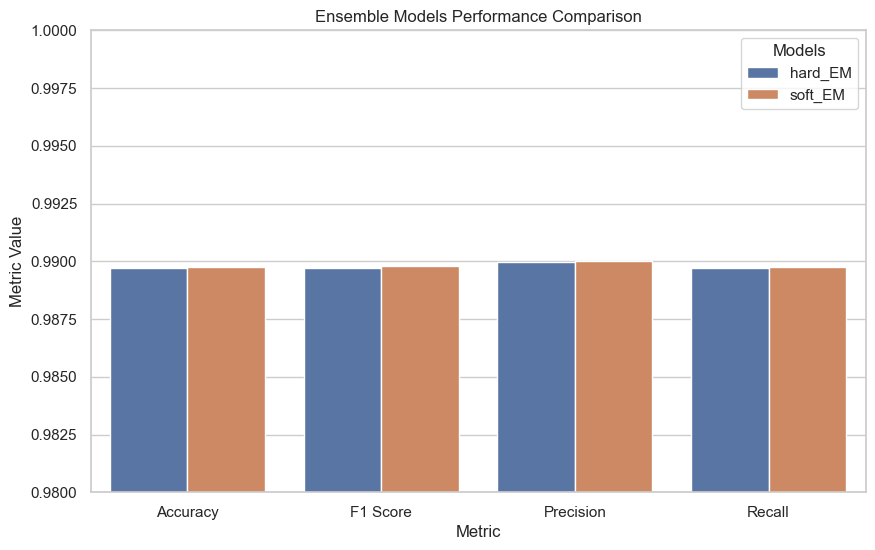

In [26]:
import matplotlib.pyplot as plt
# Plotting the dataset using Seaborn
sns.set(style="whitegrid")

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(data=a.melt(id_vars="Model", var_name="Metric"), x="Metric", y="value", hue="Model")
plt.title("Ensemble Models Performance Comparison")
plt.xlabel("Metric")
plt.ylabel("Metric Value")
plt.ylim(0.98, 1.0)  # Adjust the y-axis limits if needed
plt.legend(title="Models")

# Display the plot
plt.show()